## Fast Agent - Build a SQL Agent fast!

In [2]:
import os
from dotenv import load_dotenv

# Load envirinment
load_dotenv()

# Get data from .env file
openai_api_key= os.getenv("OPENAI_API_KEY")
langsmith_api_key=os.getenv("LANGSMITH_API_KEY")
langsmith_tracing=os.getenv("LANGSMITH_TRACING")
langsmith_project=os.getenv("LANGSMITH_PROJECT")
langsmith_endpoint=os.getenv("LANGSMITH_ENDPOINT")
#print(langsmith_endpoint)

## Load SQL Database

In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinok.db")

## Define the runtime context to provide the agent and tools with access to the database.

In [4]:
from langchain_community.utilities import SQLDatabase
from dataclasses import dataclass

# define context structure to support dependency injection

@dataclass
class RuntimeContext:
    db: SQLDatabase

## This tool will connect to the database. 
## Note the use of get_runtime to access the graph runtime context.

In [5]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """ Execute SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db
    
    try:
        return db.run(query)
    except Exception as ex:
        return f"Error: {ex}"

## Add a system prompt to define your agents behavior.

In [6]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

## Create your agent! Add a model, tools, a prompt, and the runtime access (context_schema)

In [7]:
from langchain.agents import create_agent

# Agent
agent= create_agent(
    model="gpt-5-mini-2025-08-07",
    tools=[execute_sql],
    system_prompt= SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

## Display of the agent ReAct Loop.

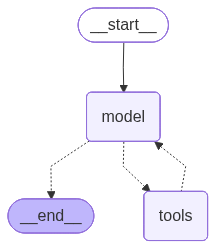

In [8]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

## Notice you invoke the agent with (agent.stream).
## - This command(agent.stream) and the (pretty_print) display the messages that communicate information between the model and the tools.

In [9]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_6skapoTn9LzsUwCBfhM2Qes3)
 Call ID: call_6skapoTn9LzsUwCBfhM2Qes3
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql


================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_Hp26wEfZUlx7uYwyKNLDyyet)
 Call ID: call_Hp26wEfZUlx7uYwyKNLDyyet
  Args:
    query: SELECT type, name, tbl_name FROM sqlite_master ORDER BY type, name LIMIT 100;
================================= Tool Message =================================
Name: execute_sql


================================== Ai Message ==================================
Tool Calls:
  execut

In [ ]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

In [ ]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

In [ ]:
question = "TRY YOUR OWN QUERY HERE"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()